# Hierarchical Inference with Redshifts

This notebook builds on the results from 2.1 and details how to use **hierarchical modeling** to infer individual and population redshift distributions from a given collection of redshift PDFs. This allows us to introduce most of the critical ideas and extensions that serve as the foundation hierarchical inference over samples and inference over $p$-D photometric PDFs.

# Setup

In [1]:
from __future__ import print_function, division
import sys
import pickle
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from six.moves import range

# import frankenz code
import frankenz

# plot in-line within the notebook
%matplotlib inline

np.random.seed(7)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

# Data

For our proof-of-concept tests, we will use the mock SDSS data we previously generated and utilized in 2.1.

In [3]:
downsample = 10  # downsampling the population
survey = pickle.load(open('../data/mock_sdss_polletta_bpz.pkl', 'rb'))  # load data
types = survey.data['types'][::downsample]
templates = survey.data['templates'][::downsample]
redshifts = survey.data['redshifts'][::downsample]
mags = survey.data['refmags'][::downsample]
Nobs = len(types)

# Population Redshift Density Estimation

For every observed galaxy $g \in \mathbf{g}$ out of $N_\mathbf{g}$ galaxies, let's assume we have an associated redshift estimate $z_g$ with PDF $P(z_g | z)$. We can construct an estimate for the population redshift distribution $N(z|\mathbf{g})$ by projecting our results onto a relevant **redshift basis** $\lbrace \dots, P(z_h|z) = K(z_h|z), \dots \rbrace$ indexed by $h \in \mathbf{h}$ via

$$
P(g|h) \rightarrow P(z_g|z_h) = \frac{P(z_g, z_h)}{P(z_h)} = \frac{\int P(z_g | z) K(z_h | z) P(z) dz}{\sum_{g \in \mathbf{g}} \int P(z_g | z) K(z_h | z) P(z) dz}
$$

where the notation $K(z_h|z)$ is meant to suggest a **kernel density** and differentiate it from $P(z_g|z)$.

In 2.1, we showed how these can be used to construct different estimates of the population distribution using different basis functions, namely Tophat kernels (i.e. bins) and Gaussian kernels. These are plotted below.

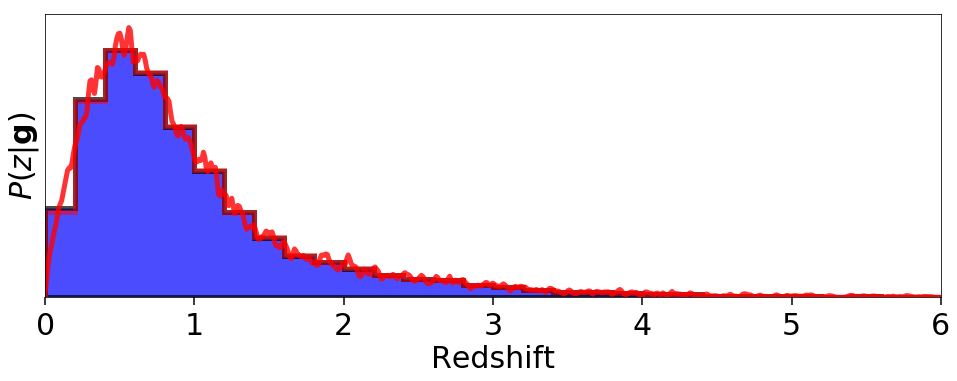

In [4]:
# bins
zbins = np.arange(0, 6.+1e-5, 0.2)  # redshift bins

# KDE
zgrid = np.arange(-1., 7.+1e-5, 0.01)
Ngrid, sgrid = len(zgrid), 0.01
pdf = frankenz.pdf.gauss_kde(redshifts, np.ones(Nobs) * sgrid, zgrid)
pdf /= np.trapz(pdf, zgrid)

# plotting
plt.figure(figsize=(14, 6))
nz, _, _ = plt.hist(redshifts, bins=zbins, histtype='stepfilled', lw=5,
                    color='blue', alpha=0.7, normed=True, edgecolor='black')
plt.plot(zgrid, pdf, lw=5, color='red', alpha=0.8)
plt.hist(zgrid + 1e-5, bins=zbins, weights=pdf, histtype='step', lw=5,
         color='red', alpha=0.5, normed=True)
plt.xlabel('Redshift')
plt.xlim([zbins[0], zbins[-1]])
plt.yticks([])
plt.ylabel('$P(z|\mathbf{g})$')
plt.tight_layout()

Let's define our PDFs to be Gaussian $\mathcal{N}(z|\mu=\hat{z}_g, \sigma=\sigma_g)$ centered around noisy estimates $\hat{z}_g$ with error $\hat{\sigma}_g$. These are truncated at $z=0$ to avoid unphysical results.

In [5]:
# generate PDFs
sigma = np.random.uniform(0.05, 0.2, size=Nobs)  # width
mu = np.random.normal(redshifts, sigma)  # noisy observation
zpdf = np.array([frankenz.pdf.gaussian(mu[i], sigma[i], zgrid) 
                 for i in range(Nobs)])  # redshift pdfs
zpdf /= np.trapz(zpdf, zgrid)[:,None]  # normalizing (dealing with edge effects)

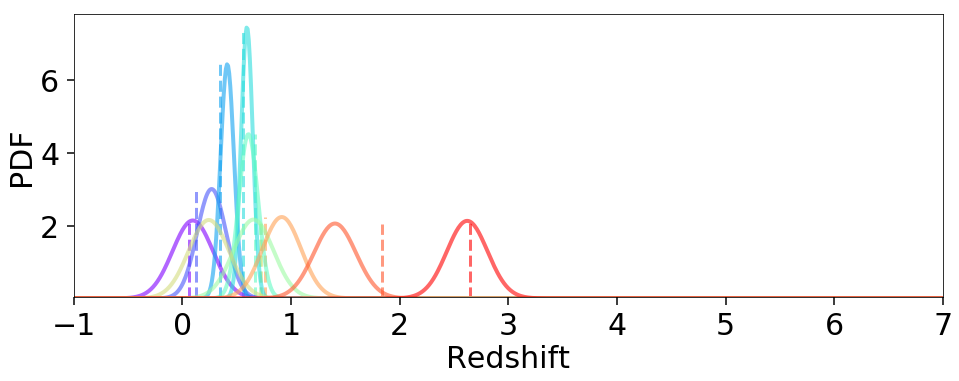

In [6]:
# plot some PDFs
plt.figure(figsize=(14, 6))
Nplot = 10
colors = plt.get_cmap('rainbow')(np.linspace(0., 1., Nplot))
zidxs = np.random.choice(Nobs, size=Nplot)
zidxs = zidxs[np.argsort(redshifts[zidxs])]
for i, c in zip(zidxs, colors):
    plt.plot(zgrid, zpdf[i], color=c, lw=4, alpha=0.6)
    plt.vlines(redshifts[i], 0., max(zpdf[i]), color=c, 
               lw=3, linestyles='--', alpha=0.6)
plt.xlim([zgrid[0], zgrid[-1]])
plt.ylim([0.03, None])
plt.xlabel('Redshift')
plt.ylabel('PDF')
plt.tight_layout()

Commonly, it is assumed that "stacking" these PDFs such that

$$
N(z|\mathbf{g}) \stackrel{?}{=} \sum_{g \in \mathbf{g}} \mathcal{N}(z|\mu=\hat{z}_g, \sigma=\hat{\sigma}_g)
$$

will give access to the population distribution. Evaluated over a particular (discrete) basis $\mathbf{h}$, we can write the effective number density $\boldsymbol{\Lambda}_\mathbf{g}$ from this stacked distribution as

$$ \boldsymbol{\Lambda}_\mathbf{g} = \sum_{g \in \mathbf{g}} \mathbf{p}_g $$

where $\mathbf{p}_g$ is the **probability mass function (PMF)** (i.e. the discrete PDF) for galaxy $g$.

In the context of the general case outlined above, this assumes that our redshift prior $P(z)$ is uniform. For illustrative purposes, we take each basis $h \rightarrow K(z_h|z) = \delta(z_h-z)$ to be a delta function.

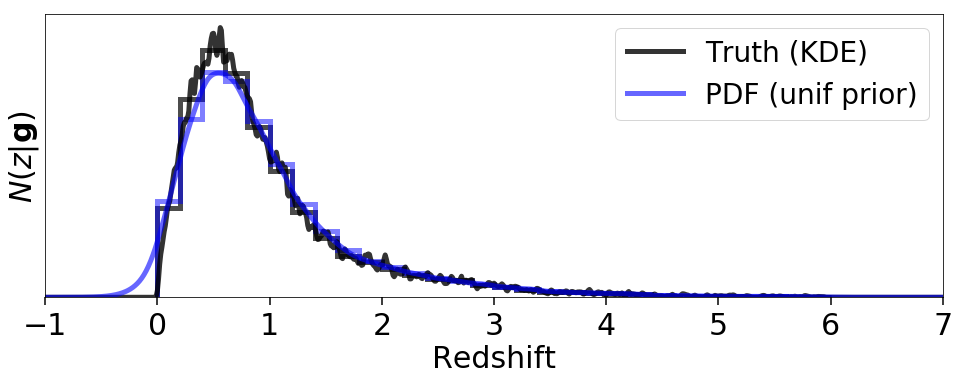

In [7]:
# plotting
plt.figure(figsize=(14, 6))
plt.plot(zgrid, pdf, lw=5, color='black', alpha=0.8,
         label='Truth (KDE)')
plt.plot(zgrid, zpdf.sum(axis=0) / Nobs, lw=5, color='blue',
         alpha=0.6, label='PDF (unif prior)')
plt.hist(redshifts, bins=zbins, histtype='step', lw=5,
         color='black', alpha=0.7, normed=True)
plt.hist(zgrid + 1e-5, bins=zbins, weights=zpdf.sum(axis=0) / Nobs,
         histtype='step', lw=5,
         color='blue', alpha=0.5, normed=True)
plt.xlabel('Redshift')
plt.xlim([zgrid[0], zgrid[-1]])
plt.yticks([])
plt.ylabel('$N(z|\mathbf{g})$')
plt.ylim([0., None])
plt.legend(fontsize=28, loc='best')
plt.tight_layout()

# Population Modeling

Following the previous notebook (2.1), we now want to derive *errors* around our $N(h|\mathbf{g})$ predictions from our underlying PDFs $\lbrace \mathbf{p}_g\rbrace$ under a given prior $\boldsymbol{\pi}_{\mathbf{g}}$. In particular, we want to generate a series of $k$ samples 

$$ \mathbf{n}_{\mathbf{g}}^{(1)}, \dots, \mathbf{n}_{\mathbf{g}}^{(k)} | \lbrace \mathbf{p}_g\rbrace, \boldsymbol{\pi}_{\mathbf{g}} \sim P(\mathbf{n}_{\mathbf{g}}|\lbrace \mathbf{p}_g\rbrace, \boldsymbol{\pi}_{\mathbf{g}}) $$ 

where $\mathbf{n}_{\mathbf{g}} = \lbrace \dots, n_h(\mathbf{g}), \dots \rbrace = \lbrace \dots, N(h|\mathbf{g}), \dots \rbrace$ are the (effective) observed counts. Using histograms and bins, these are just integer counts; using KDE with Gaussian kernels, however, makes these more like number density estimates.

In [8]:
# number of samples
Nsamples = 50

Deriving $P(\mathbf{n}_{\mathbf{g}}|\lbrace \mathbf{p}_g\rbrace, \boldsymbol{\pi}_{\mathbf{g}})$ often involves marginalizing over some set of **nuisance parameters** $\boldsymbol{\phi}$, which often can be computationally demanding. Instead, we can fix $\boldsymbol{\phi}$ to its **maximum-likelihood (ML)** value $\boldsymbol{\phi}_{\textrm{ML}}$ such that

$$ \mathbf{n}_{\mathbf{g}}^{(1)}, \dots, \mathbf{n}_{\mathbf{g}}^{(k)} | \lbrace \mathbf{p}_g\rbrace, \boldsymbol{\pi}_{\mathbf{g}} \sim P(\mathbf{n}_{\mathbf{g}}|\lbrace \mathbf{p}_g\rbrace, \boldsymbol{\pi}_{\mathbf{g}},\boldsymbol{\phi}_{\textrm{ML}}) $$

## Poisson Approximation

A common approximation is that there are some number of galaxies $N_h$ within the $h$-th redshift bin, and we observe some random realization of this underlying count. The number of objects in each bin (assuming they're independent from each other) then follows a **Poisson distribution** where

$$ n_h|\lbrace \mathbf{p}_g\rbrace, \boldsymbol{\pi}_{\mathbf{g}} \sim \textrm{Pois}\left(\lambda = \lambda_{\textrm{ML},h}(\lbrace \mathbf{p}_g\rbrace, \boldsymbol{\pi}_{\mathbf{g}})\right) $$

The ML solution for the combined set of $\boldsymbol{\lambda}_{\mathbf{g}}$ is

$$ \boldsymbol{\lambda}_{\mathbf{g},\textrm{ML}}(\lbrace \mathbf{p}_g\rbrace, \boldsymbol{\pi}_{\mathbf{g}}) = \tilde{\boldsymbol{\Lambda}}_{\mathbf{g}} $$

where 

$$ \tilde{\boldsymbol{\Lambda}}_{\mathbf{g}} = \sum_{g \in \mathbf{g}} \frac{\mathbf{p}_g \odot \boldsymbol{\pi}_{\mathbf{g}}}{\sum_{h \in \mathbf{h}} p_{g,h} \cdot \pi_h} = \sum_{g \in \mathbf{g}} \tilde{\mathbf{p}}_g $$

is the new set of effective counts and $\odot$ represents the **Hadamard product** (element-wise multiplication). Note that for $\boldsymbol{\pi}_{\mathbf{g}} = \mathbf{1}$, $\tilde{\mathbf{p}}_g=\mathbf{p}_g$ and $\tilde{\boldsymbol{\Lambda}}_\mathbf{g} = \boldsymbol{\Lambda}_\mathbf{g}$.

Our final result is then

$$ n_h|\lbrace \mathbf{p}_g\rbrace, \boldsymbol{\pi}_{\mathbf{g}} \sim \textrm{Pois}\left(\lambda = \tilde{\Lambda}_h \right) $$

In [9]:
# draw Poisson samples
pdf1 = zpdf.sum(axis=0)  # stack PDFs
pdf1 /= pdf1.sum()  # normalize
pdf1 *= Nobs  # transform to counts
pdf1_samples = np.array([np.random.poisson(pdf1) 
                         for i in range(Nsamples)])  # draw samples

## Multinomial Approximation

An alternate approximation is to assume our observed counts $\mathbf{n_h}$ are drawn from the **Multinomial distribution**, whose ML result is

$$ \mathbf{n}_{\mathbf{h}}|\lbrace \mathbf{p}_g\rbrace, \boldsymbol{\pi}_{\mathbf{g}} \sim \textrm{Mult}\left(n = N_\mathbf{g}, \mathbf{p} = \boldsymbol{\Lambda}_\mathbf{g}/N_\mathbf{g}\right)
$$

In [10]:
# draw multinomial samples
pdf2_samples = np.random.multinomial(Nobs, pdf1 / pdf1.sum(),
                                     size=Nsamples)  # samples

## Posterior Samples

Any particular galaxy $g$ with PDF $\mathbf{p}_g = \lbrace \dots, P(z_h|g), \dots \rbrace$ is actually located at a particular redshift $z_g \in \lbrace \dots, z_h \dots \rbrace$, with the corresponding redshift PDF modeling our uncertainty over its true redshift. Given $\mathbf{p}_g$, the distribution of $z_g$ ($\mathbf{n}_g$) is Categorial (Multinomial) such that

$$
z_g|\mathbf{p}_g,\boldsymbol{\pi}_\mathbf{g} \sim \textrm{Cat}\left(\mathbf{p}=\tilde{\mathbf{p}}_g\right)
\quad \Leftrightarrow \quad 
\mathbf{n}_g|\mathbf{p}_g,\boldsymbol{\pi}_\mathbf{g} \sim \textrm{Mult}\left(n=1, \mathbf{p}=\tilde{\mathbf{p}}_g\right)
$$

The redshift number density is then

$$
\mathbf{n}_\mathbf{g}|\lbrace\mathbf{p}_g\rbrace,\boldsymbol{\pi}_\mathbf{g} = \sum_{g \in \mathbf{g}} \mathbf{n}_g|\mathbf{p}_g,\boldsymbol{\pi}_\mathbf{g}
$$

This represents a convolution of a series of Categorical random variables with different PDFs. Since $\tilde{\boldsymbol{\Lambda}}_\mathbf{g} = \sum_{g \in \mathbf{g}} \tilde{\mathbf{p}}_g$, this implicitly includes the population distribution through each of the individual objects. There are no nuisance parameters to optimize/marginalize over in this case.

In [11]:
# draw posterior samples
pdf3_samples = np.zeros_like(pdf1_samples)
zpdf_norm = zpdf / zpdf.sum(axis=1)[:, None]
for j in range(Nsamples):
    sys.stderr.write(' {0}'.format(j))
    for i in range(Nobs):
        # stack categorial draw
        pdf3_samples[j] += np.random.multinomial(1, zpdf_norm[i])

 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49

Let's plot our results to see how we've done.

In [12]:
def zplot(samples, label='type', color='blue'):
    """Plot our draws."""
    
    [plt.plot(zgrid, samples[i], lw=2, color=color, alpha=0.07)
     for i in range(Nsamples)]
    plt.plot(zgrid, pdf/pdf.sum() * Nobs, lw=5, color='black',
             alpha=0.7)
    plt.plot(zgrid, pdf * 0.0 - 1e4, lw=3, color=color,
             alpha=0.5, label=label)
    plt.xlabel('Redshift')
    plt.xlim([zgrid[0], zgrid[-1]])
    plt.yticks([])
    plt.ylim([0, max(pdf / pdf.sum() * Nobs) * 1.2])
    plt.ylabel('$N(z|\mathbf{g})$')
    plt.legend(fontsize=26, loc='best')
    plt.tight_layout()

In [13]:
def zplot_bin(samples, label='type', color='blue', binning=5):
    """Plot our binned draws."""
    [plt.hist(zgrid + 1e-5, zgrid[::binning], 
              weights=samples[i], lw=3,
              histtype='step', color=color, alpha=0.15) 
     for i in range(Nsamples)]
    plt.hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step',
             color=color, alpha=0.6, label=label)
    h = plt.hist(redshifts, zgrid[::binning], 
                 histtype='step', lw=6, color='black', alpha=0.7)
    plt.xlabel('Redshift')
    plt.xlim([zgrid[0], zgrid[-1]])
    plt.yticks([])
    plt.ylim([0, max(h[0]) * 1.2])
    plt.ylabel('$N(z|\mathbf{g})$')
    plt.legend(fontsize=26, loc='best')
    plt.tight_layout()

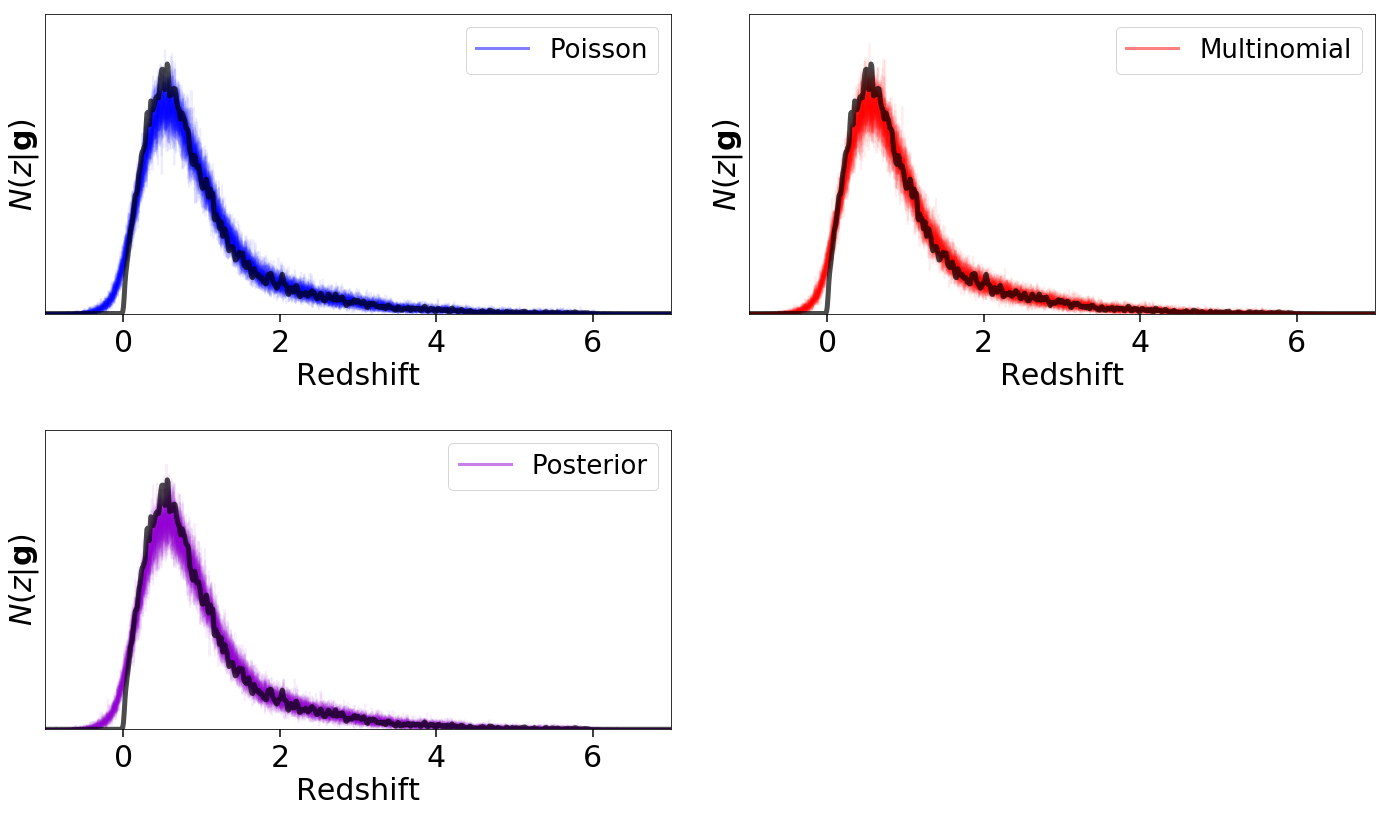

In [14]:
# plotting results
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot(pdf1_samples, label='Poisson', color='blue')
plt.subplot(2, 2, 2)
zplot(pdf2_samples, label='Multinomial', color='red')
plt.subplot(2, 2, 3)
zplot(pdf3_samples, label='Posterior', color='darkviolet')

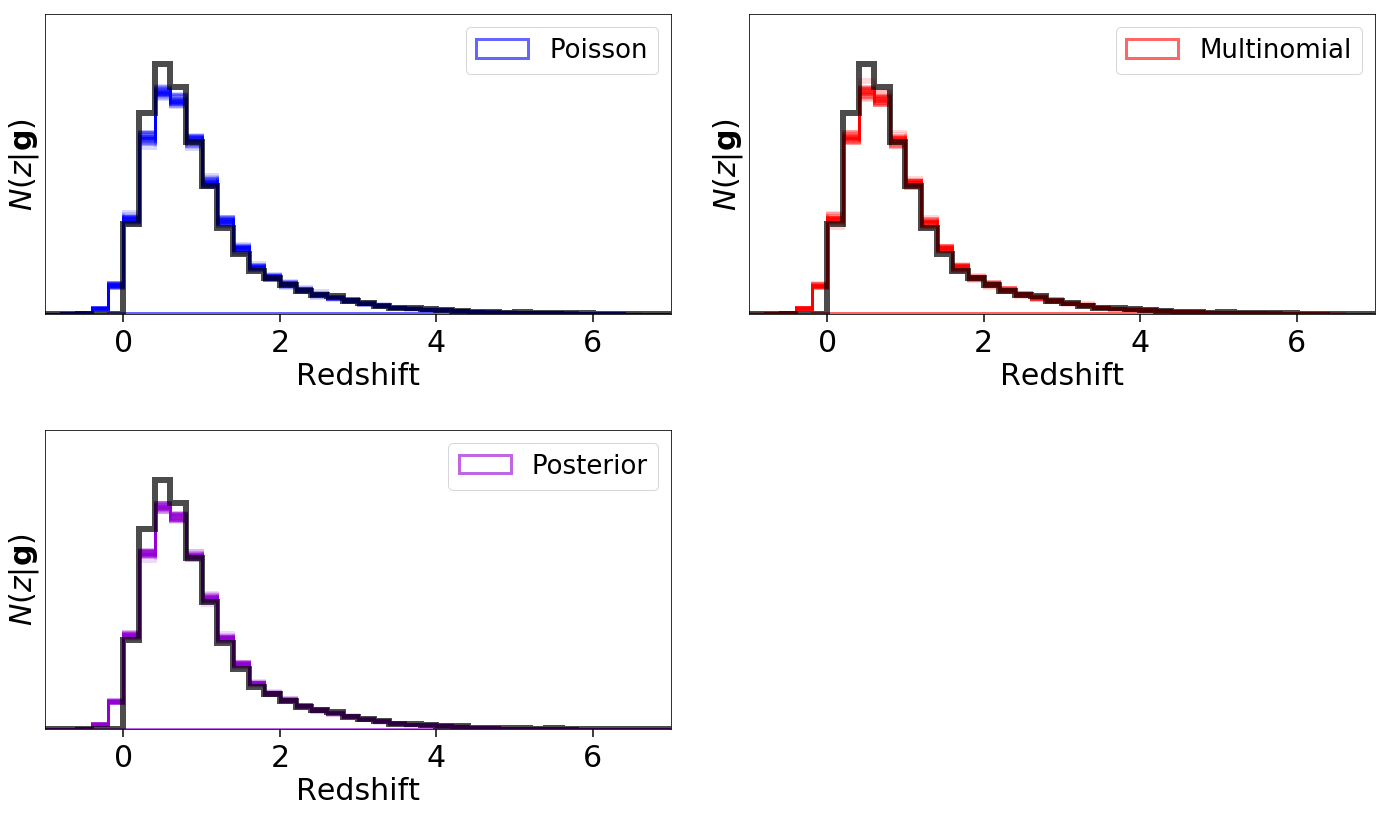

In [15]:
# plotting binned results
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot_bin(pdf1_samples, label='Poisson', color='blue', binning=20)
plt.subplot(2, 2, 2)
zplot_bin(pdf2_samples, label='Multinomial', color='red', binning=20)
plt.subplot(2, 2, 3)
zplot_bin(pdf3_samples, label='Posterior', color='darkviolet', binning=20)

# Hierarchical Modeling

So far, we've used our PDFs $\mathbf{p}_g$ computed a fixed, uniform prior $\boldsymbol{\pi}_\mathbf{g}=1$ to construct estimates of the population distribution $\mathbf{p}_\mathbf{g}$. But the resulting population distribution is quite far from uniform. We are thus interested in probing the **joint distribution** of $P(\mathbf{n}_\mathbf{g}, \boldsymbol{\pi}_\mathbf{g}|\boldsymbol{\phi})$ using **hierarchical modeling** conditioned on some set of **hyperparameters** $\boldsymbol{\phi}$ and **hyperpriors** $P(\boldsymbol{\phi})$.

## Hyperpriors

Instead of a uniform prior, a "natural" prior for the Categorical/Multinomial is the **Dirichlet distribution** $\textrm{Dir}(\boldsymbol{\alpha})$ with concentration vector $\boldsymbol{\alpha}$, which is the **conjugate prior** to the Categorical/Multinomial. Under this Dirichlet prior, our new model becomes

$$ \boldsymbol{\pi}_\mathbf{g}|\boldsymbol{\alpha} \sim \textrm{Dir}(\boldsymbol{\alpha}) $$

$$
\mathbf{n}_\mathbf{g}|\lbrace\mathbf{p}_g\rbrace,\boldsymbol{\pi}_\mathbf{g} = \sum_{g \in \mathbf{g}} \mathbf{n}_g|\mathbf{p}_g,\boldsymbol{\pi}_\mathbf{g}, 
\quad
\mathbf{n}_g|\mathbf{p}_g,\boldsymbol{\pi}_\mathbf{g} \sim \textrm{Mult}\left(n=1, \mathbf{p}=\tilde{\mathbf{p}}_g\right)
$$

$\boldsymbol{\alpha}$ here functions as a set of **pseudo-counts** for each category, while the Dirichlet imposes similar structure on the prior as the Multinomial. Here we will take $\alpha_h(z_h)=1$ for $z_h \geq 0$ and $\alpha_h = 0.01$ for $z_h < 0$.

In [16]:
# initialize concentration parameters
alpha = np.ones(Ngrid)
alpha[zgrid < 0.] = 1e-3

## Sampling the Joint Distribution

How do we sample from such the joint distribution $P(\mathbf{n}_\mathbf{g}, \boldsymbol{\pi}_\mathbf{g}|\lbrace\mathbf{p}_g\rbrace,\boldsymbol{\alpha})$ using, e.g., **Markov Chain Monte Carlo (MCMC)**? The joint distribution does not exist in analytic form, and given that we are trying to sample $2 \times N_h$ parameters, it is intractable for typical **rejection samplers** that try and probe the joint distribution directly using, e.g., **Metropolis proposals**.

It is, however, particularly amenable to **Gibbs sampling**, which allows us to sample from joint distribution by iteratively sampling from the associated conditional distributions:

\begin{align}
\mathbf{n}_g^{(i)}|\mathbf{p}_g,\boldsymbol{\pi}_\mathbf{g}^{(i-1)} &\sim \textrm{Mult}\left(n=1, \mathbf{p}=\tilde{\mathbf{p}}_g^{(i-1)}\right) \\
\mathbf{n}_\mathbf{g}^{(i)}|\lbrace\mathbf{p}_g\rbrace,\boldsymbol{\pi}_\mathbf{g}^{(i-1)},\boldsymbol{\alpha} = \mathbf{n}_\mathbf{g}^{(i)}|\lbrace\mathbf{p}_g\rbrace,\boldsymbol{\pi}_\mathbf{g}^{(i-1)} &=  \sum_{g \in \mathbf{g}} \mathbf{n}_g^{(i)}|\mathbf{p}_g,\boldsymbol{\pi}_\mathbf{g}^{(i-1)}, \\
\boldsymbol{\pi}_\mathbf{g}^{(i)}|\lbrace\mathbf{p}_g\rbrace,\mathbf{n}_\mathbf{g}^{(i)},\boldsymbol{\alpha} = \boldsymbol{\pi}_\mathbf{g}^{(i)}|\mathbf{n}_\mathbf{g}^{(i)},\boldsymbol{\alpha} &\sim \textrm{Dir}(\mathbf{n}_\mathbf{g}^{(i)} + \boldsymbol{\alpha})
\end{align}

This gives us a straightforward scheme for sampling:
1. Sample individual redshifts from their new PDFs using the prior weights $\boldsymbol{\pi}_\mathbf{g}^{(i-1)}$ sampled from the previous iteration.
2. Add up the total number of counts to derive $\mathbf{n}_\mathbf{g}^{(i)}$.
3. Sample the prior weights using the current number of counts $\mathbf{n}_\mathbf{g}^{(i)}$.

As with any MCMC sampler, we need time to "burn in" to the stationary distribution and often some subsequent thinning of the to ensure (relatively more) independent samples. We check both of these conditions below by looking at the autocorrelation time for a few of our redshift grid points and the general autocorrelation for $\Delta t=1$.

In [17]:
def mcmc_gibbs(pdfs, Nsamples, Ngrid,
               Nburn=0, Nthin=1, verbose=True):
    """Using MCMC with Gibbs sampling to sample from
    the joint distribution of our hierarchical model."""
    
    Nobs = len(pdfs)
    samples_pi = np.zeros((Nsamples, Ngrid))
    samples_n = np.zeros((Nsamples, Ngrid), dtype='int')

    prior = np.ones(Ngrid)  # initialize weights
    for j in range(Nthin * (Nsamples + Nburn)):
        count = int(j / Nthin) - Nburn
        if verbose and (j + 1) % Nthin == 0: 
            sys.stderr.write('{0} '.format(count))

        # Compute new posterior.
        nstack = np.zeros(Ngrid)
        pdf_t = pdfs * prior
        pdf_t /= pdf_t.sum(axis=1)[:, None]

        # Stack posterior.
        for i in range(Nobs):
            nstack += np.random.multinomial(1, pdf_t[i])

        # Sample population weights.
        prior = np.random.dirichlet(nstack + alpha)

        # Save samples.
        if (j + 1) % Nthin == 0 and count >= 0:
            samples_n[count] = nstack.copy()
            samples_pi[count] = prior.copy()
            
    return samples_n, samples_pi

In [18]:
# sample from our hierarchical model
pdf4_samples_n, pdf4_samples_pi = mcmc_gibbs(zpdf, 200, Ngrid,
                                             Nburn=0, Nthin=2)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

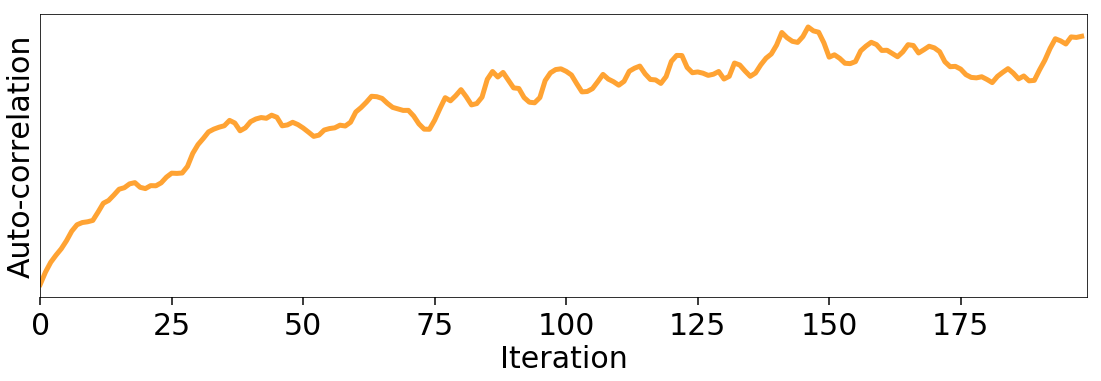

In [19]:
# plot lag=1 autocorrelation
plt.figure(figsize=(16, 6))
autocorr = np.array([np.correlate(pdf4_samples_n[i], pdf4_samples_n[i+1])
                     for i in range(len(pdf4_samples_n) - 1)]).flatten()
plt.plot(autocorr, lw=5, color='darkorange', alpha=0.8)
plt.xlabel('Iteration')
plt.xlim([0., len(pdf4_samples_n) - 1])
plt.yticks([])
plt.ylabel('Auto-correlation')
plt.tight_layout()

It seems we've approximately burned in after $\sim 150 \times 2 = 300$ samples. We'll double that later to be safe.

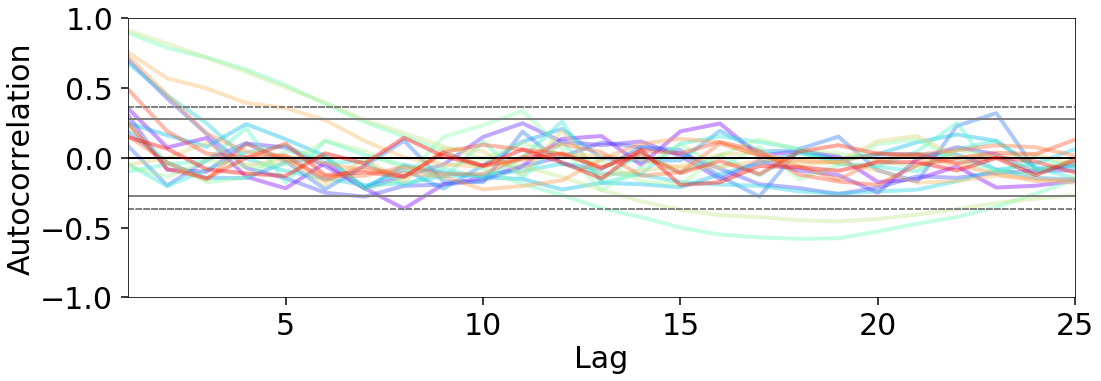

In [20]:
from pandas.plotting import autocorrelation_plot

# plot autocorrelation lag
Nburnin = 150
Nplot = 20
plt.figure(figsize=(16, 6))
colors = plt.get_cmap('rainbow')(np.linspace(0., 1., Nplot))
idxs = np.random.choice(len(zgrid), size=Nplot, replace=False)
[autocorrelation_plot(pdf4_samples_pi[Nburnin:, i], 
                      color=c, lw=4, alpha=0.4) 
 for i, c in zip(idxs, colors)]
plt.xlim([1, (len(pdf4_samples_n) - Nburnin) / 2])
plt.tight_layout()

While most of our samples are uncorrelated, a few have longer autocorrelation lengths. We'll pick 10 as a thinning timescale.

In [21]:
# sample from our hierarchical model
pdf4_samples_n, pdf4_samples_pi = mcmc_gibbs(zpdf, Nsamples, Ngrid,
                                             Nburn=50, Nthin=10)

-50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

## Results

Now let's take a look at our final results.

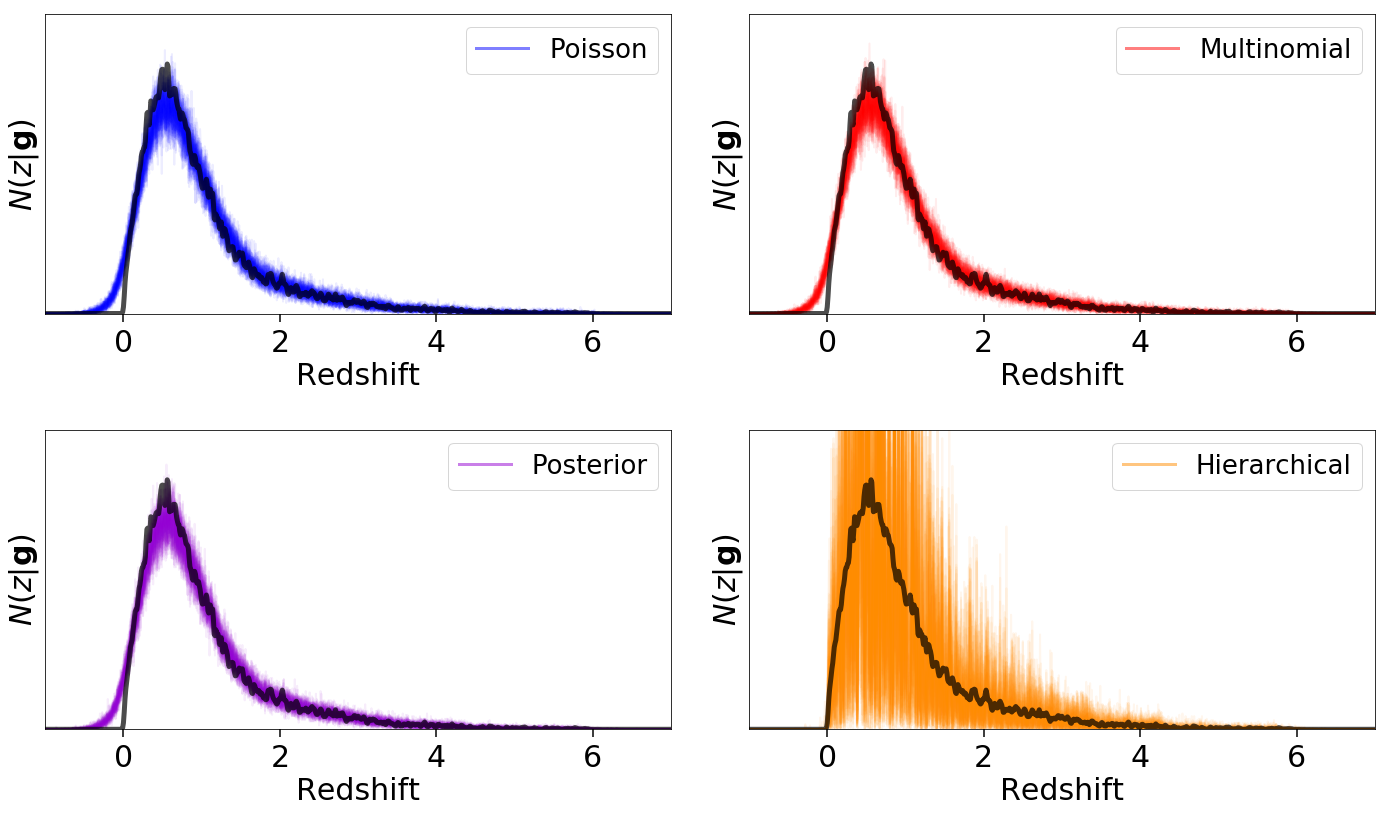

In [22]:
# plotting
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot(pdf1_samples, label='Poisson', color='blue')
plt.subplot(2, 2, 2)
zplot(pdf2_samples, label='Multinomial', color='red')
plt.subplot(2, 2, 3)
zplot(pdf3_samples, label='Posterior', color='darkviolet')
plt.subplot(2, 2, 4)
zplot(pdf4_samples_n, label='Hierarchical', color='darkorange')

Our hierarchical sample appears to experience some enourmous variation! There are a few primary reasons for this. Most crucially, our Dirichlet distribution is fundamentally an unordered distribution over our grid. By disregarding the fact that the amplitude of nearby redshift bins should inherently be strongly correlated with each other, it allows for more (unphysical) variation than might otherwise be possible. In addition, our PDFs are relatively broad compared to the resolution of our redshift grid ($\sigma_z \approx 0.05$ compared with $\Delta z = 0.02$), especially given the size of our sample (20k galaxies). This lends itself to a lot of possible sample variation since the total "number" of galaxies occupying a given redshift is (relatively) low.

These very noisy results, however, still can be leveraged to give good predictions at coarser resolutions, as shown below.

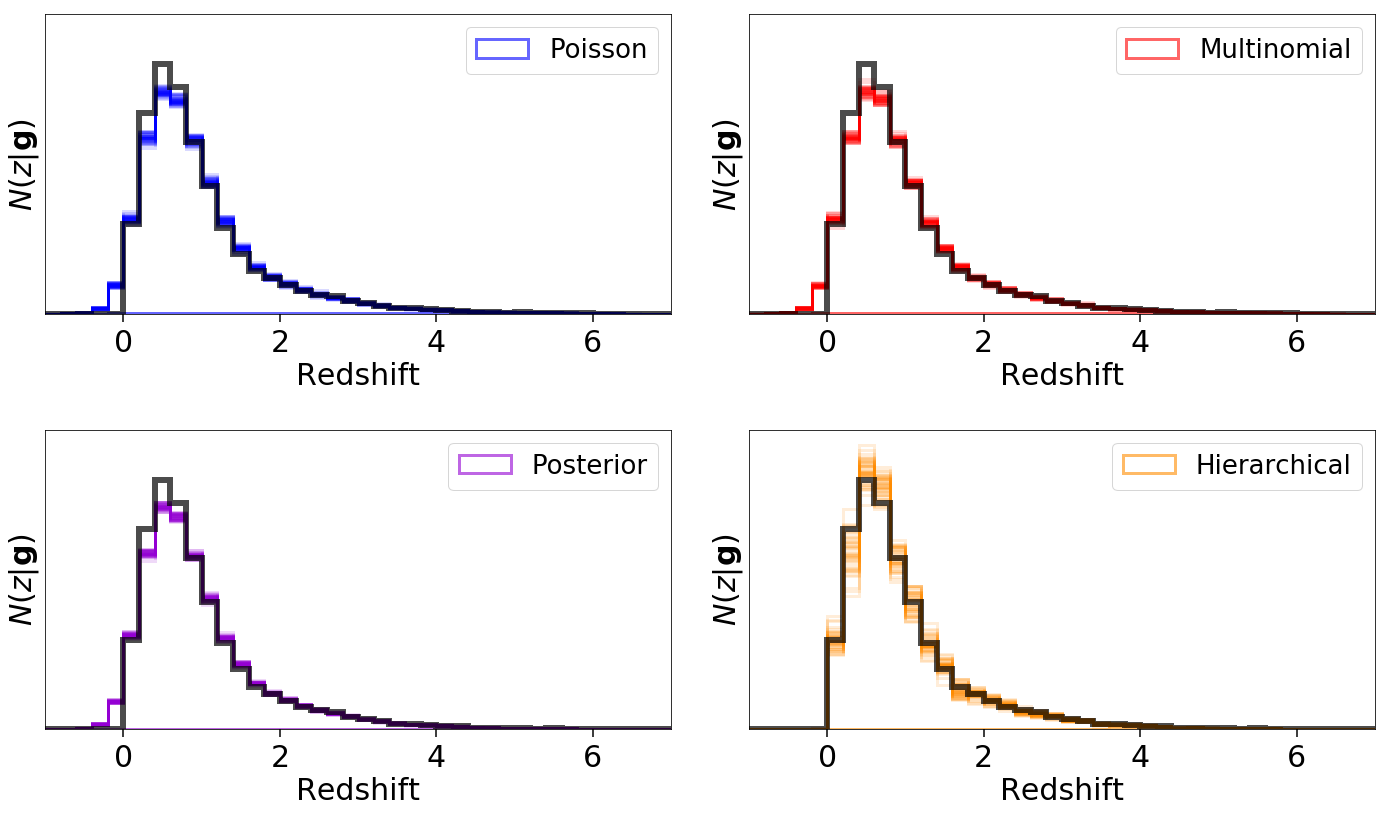

In [23]:
# plotting binned results
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot_bin(pdf1_samples, label='Poisson', color='blue', binning=20)
plt.subplot(2, 2, 2)
zplot_bin(pdf2_samples, label='Multinomial', color='red', binning=20)
plt.subplot(2, 2, 3)
zplot_bin(pdf3_samples, label='Posterior', color='darkviolet', binning=20)
plt.subplot(2, 2, 4)
zplot_bin(pdf4_samples_n, label='Hierarchical', color='darkorange', binning=20)

Only our hierarchical model is able to properly recover the true underlying distribution.

Another way to visualize our results is by looking at the covariances between neighboring redshift bins. We'll just take a look at one here.

In [24]:
def cov_draws(samples, bin1=(60, 80), bin2=(80, 100), color='blue', 
              label='label', xlim=None, ylim=None):
    """Plot our draws within two bins."""

    # Bin results.
    n, _ = np.histogram(redshifts, bins=zgrid)
    pdf_bin1 = n[bin1[0]:bin1[1]].sum() / n.sum() * Nobs / 1e3
    pdf_bin2 = n[bin2[0]:bin2[1]].sum() / n.sum() * Nobs / 1e3
    samples_bin1 = samples[:, bin1[0]:bin1[1]].sum(axis=1) / 1e3
    samples_bin2 = samples[:, bin2[0]:bin2[1]].sum(axis=1) / 1e3
    
    # Plot results.
    plt.vlines(pdf_bin1, 0, 100, lw=2, colors='black', linestyles='--')
    plt.hlines(pdf_bin2, 0, 100, lw=2, colors='black', linestyles='--')
    plt.plot(pdf_bin1, pdf_bin2, 's', color='black', markersize=20)
    plt.plot(samples_bin1, samples_bin2, 'o', color=color, 
             label=label, markersize=15, alpha=0.6)
    if xlim is None:
        plt.xlim([min(pdf_bin1, min(samples_bin1)) - 0.1, 
                  max(pdf_bin1, max(samples_bin1)) + 0.1])
    else:
        plt.xlim(xlim)
    if ylim is None:
        plt.ylim([min(pdf_bin2, min(samples_bin2)) - 0.1, 
                  max(pdf_bin2, max(samples_bin2)) + 0.1])
    else:
        plt.ylim(ylim)
    plt.xlabel(r'$N({0}\leq z < {1}) \quad [10^3]$'.format(zgrid[bin1[0]], 
                                                           zgrid[bin1[1]]))
    plt.ylabel(r'$N({0}\leq z < {1}) \quad [10^3]$'.format(zgrid[bin2[0]], 
                                                           zgrid[bin2[1]]))
    plt.legend(fontsize=28, loc=1)
    plt.tight_layout()

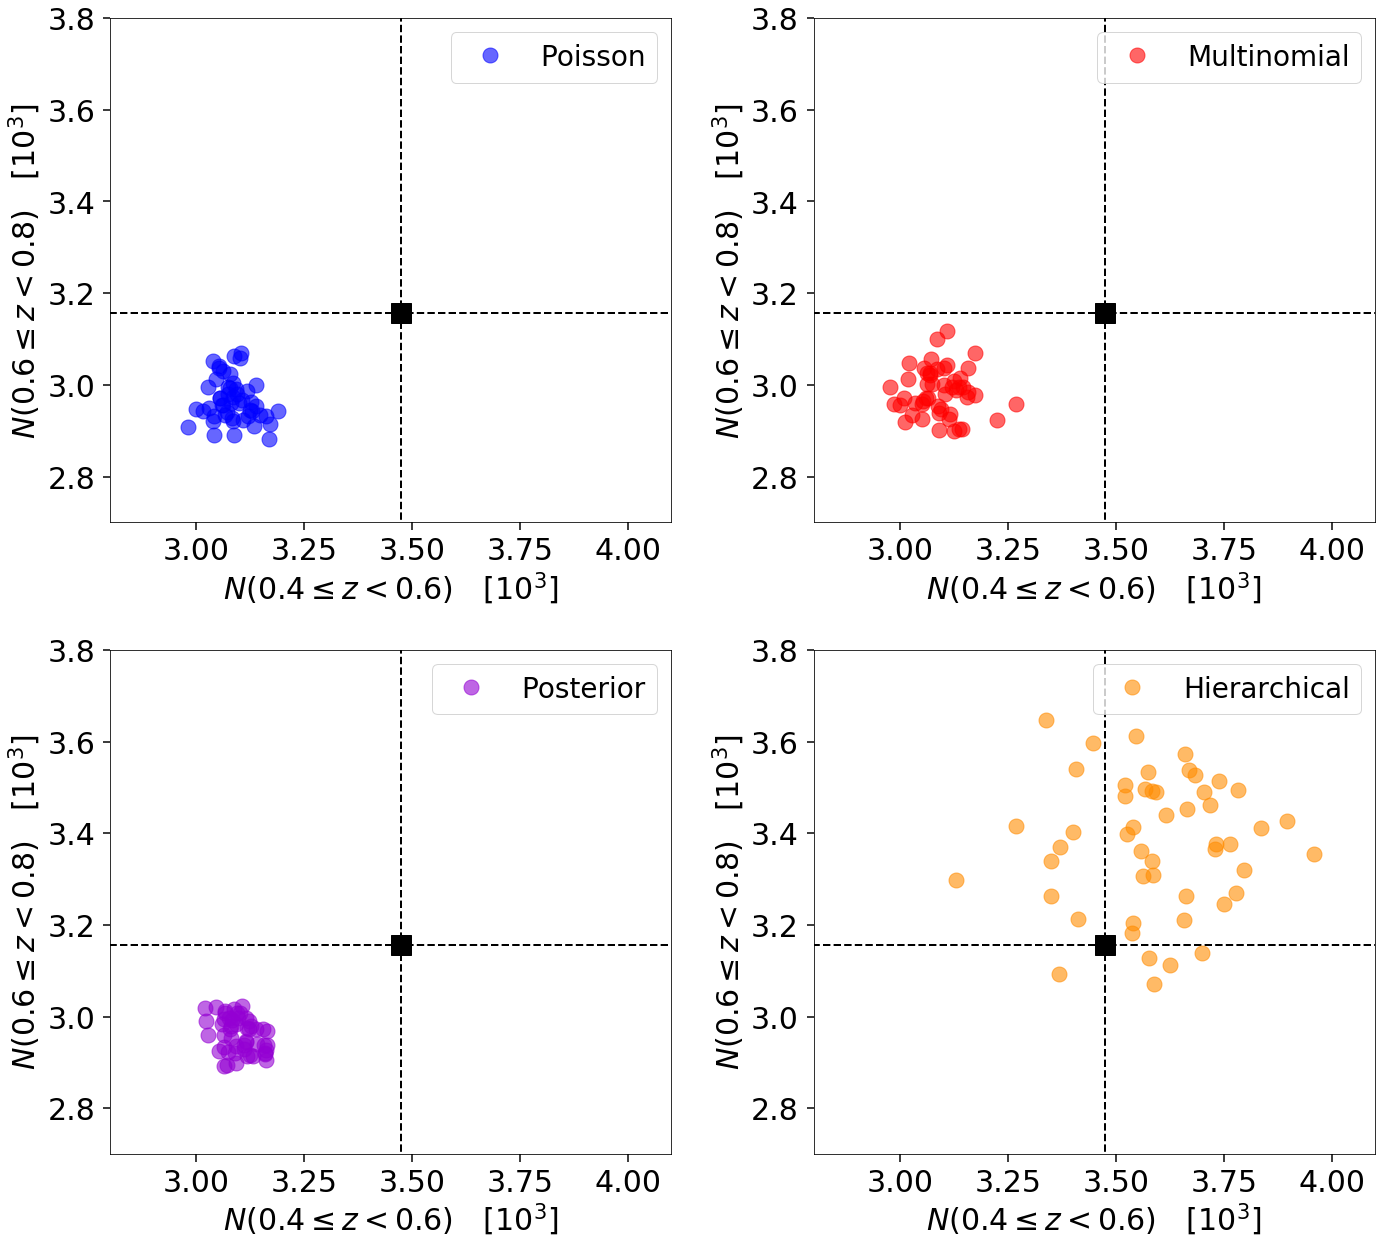

In [25]:
# plotting binned covariance
plt.figure(figsize=(20,18))
plt.subplot(2,2,1)
cov_draws(pdf1_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 4.1), ylim=(2.7, 3.8),
          color='blue', label='Poisson')
plt.subplot(2,2,2)
cov_draws(pdf2_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 4.1), ylim=(2.7, 3.8),
          color='red', label='Multinomial')
plt.subplot(2,2,3)
cov_draws(pdf3_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 4.1), ylim=(2.7, 3.8),
          color='darkviolet', label='Posterior')
plt.subplot(2,2,4)
cov_draws(pdf4_samples_n, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 4.1), ylim=(2.7, 3.8),
          color='darkorange', label='Hierarchical')

Our behavior is as we expect: our Poisson model, which draws samples independently from the population, is not correlated. Our multinomial model is very weakly anti-correlated. Our posterior model is strongly anti-correlated and more concentrated, since objects tend to have narrower PDFs as compared with the full sample. Finally, our hierarchical model shifts the mean closer to the truth while also retaining intrinsic anti-correlations and (properly) inflating the uncertainties.

Finally, let's take a look at our new PDFs, marginalizing over the prior weights.

In [26]:
# construct PDFs marginalized over the prior weights
zpdf_new = np.zeros_like(zpdf)
for prior in pdf4_samples_pi:
    zpdf_t = zpdf * prior
    zpdf_t /= np.trapz(zpdf_t, zgrid)[:, None]
    zpdf_new += zpdf_t / Nsamples

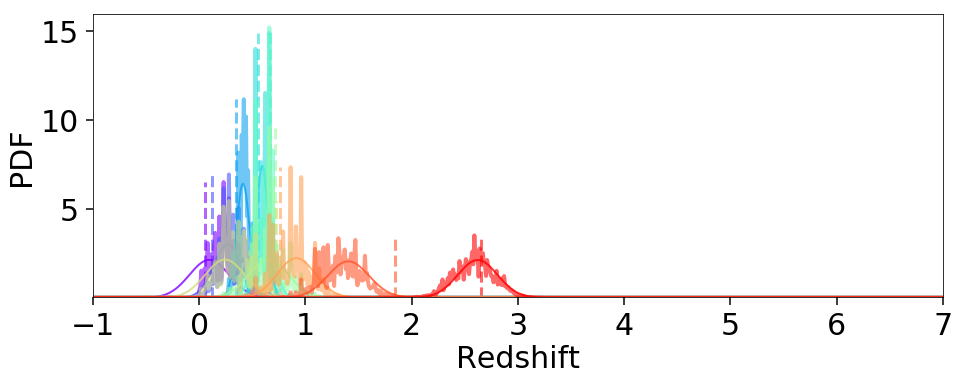

In [27]:
# plot our new PDFs
plt.figure(figsize=(14, 6))
colors = plt.get_cmap('rainbow')(np.linspace(0., 1., len(zidxs)))
for i, c in zip(zidxs, colors):
    plt.plot(zgrid, zpdf[i], color=c, lw=2, alpha=0.8)
    plt.plot(zgrid, zpdf_new[i], color=c, lw=4, alpha=0.6)
    plt.vlines(redshifts[i], 0., max(zpdf_new[i]), color=c, 
               lw=3, linestyles='--', alpha=0.6)
plt.xlim([zgrid[0], zgrid[-1]])
plt.ylim([0.03, None])
plt.xlabel('Redshift')
plt.ylabel('PDF')
plt.tight_layout()